# Student Segmentation 
- Web-based Clustering Application Using a Shiny Framework for Determining Student Engagement Levels in Virtual Learning Environments

In [1]:
# Measure Model Execution Time
import time

# Data Manipulation
import pandas as pd 

# Mathematical Operations 
import numpy as np

# Data Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# K-means Clustering 
from sklearn.cluster import KMeans

# Gaussian Mixture Model (GMM)
from sklearn.mixture import GaussianMixture

# Optimal Number of Cluster Selection & Visualisation
from yellowbrick.cluster import KElbowVisualizer

# Data Standardization 
from sklearn.preprocessing import StandardScaler

# Clustering Model Evaluation Metrics
from sklearn.metrics import silhouette_score 
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

### Student Virtual Learning Environment
The studentVle.csv file contains information about each student’s interactions with the materials in the VLE. This file contains the following columns:

- `code_module` – an identification code for a module.
- `code_presentation` - the identification code of the module presentation.
- `id_student` – a unique identification number for the student.
- `id_site` - an identification number for the VLE material.
- `date` – the date of student’s interaction with the material measured as the number of days since the start of the module-presentation.
- `sum_click` – the number of times a student interacts with the material in that day.

In [2]:
df_studentVle = pd.read_csv('oulad/studentVle.csv')

In [3]:
df_studentVle.sample(10)

,code_module,code_presentation,id_student,id_site,date,sum_click
1299214,BBB,2014B,411895,768376,43,1
8247681,FFF,2013J,592640,716303,211,1
2384159,CCC,2014B,1678800,729674,221,1
24582,AAA,2013J,228082,546667,10,4
7475089,FFF,2013J,184720,716246,22,6
9231589,FFF,2014J,674226,883037,11,1
525260,BBB,2013B,186988,542891,54,10
10255751,FFF,2014J,575069,973777,241,51
3787032,DDD,2013J,469389,673537,14,12
920223,BBB,2013J,528464,703894,53,7


**Dataset Information**

In [4]:
df_studentVle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10655280 entries, 0 to 10655279
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   code_module        object
 1   code_presentation  object
 2   id_student         int64 
 3   id_site            int64 
 4   date               int64 
 5   sum_click          int64 
dtypes: int64(4), object(2)
memory usage: 487.8+ MB


**Unique categories/values**

In [5]:
# Unique Code presentations 
df_studentVle['code_presentation'].value_counts()

2014J    3619452
2013J    2988784
2014B    2160176
2013B    1886868
Name: code_presentation, dtype: int64

In [6]:
# Unique Code module
df_studentVle['code_module'].value_counts()

FFF    4014499
DDD    2166486
BBB    1567564
CCC    1207827
EEE     961433
GGG     387173
AAA     350298
Name: code_module, dtype: int64

**Percentage of Missing Values**

In [7]:
# Percentage of missing values in each column
df_studentVle.isnull().sum()/len(df_studentVle) * 100

code_module          0.0
code_presentation    0.0
id_student           0.0
id_site              0.0
date                 0.0
sum_click            0.0
dtype: float64

### Descriptive Statistics of Sum of Clicks

In [8]:
df_studentVle['sum_click'].describe().apply(lambda x: '%.5f' % x)

count    10655280.00000
mean            3.71695
std             8.84905
min             1.00000
25%             1.00000
50%             2.00000
75%             3.00000
max          6977.00000
Name: sum_click, dtype: object

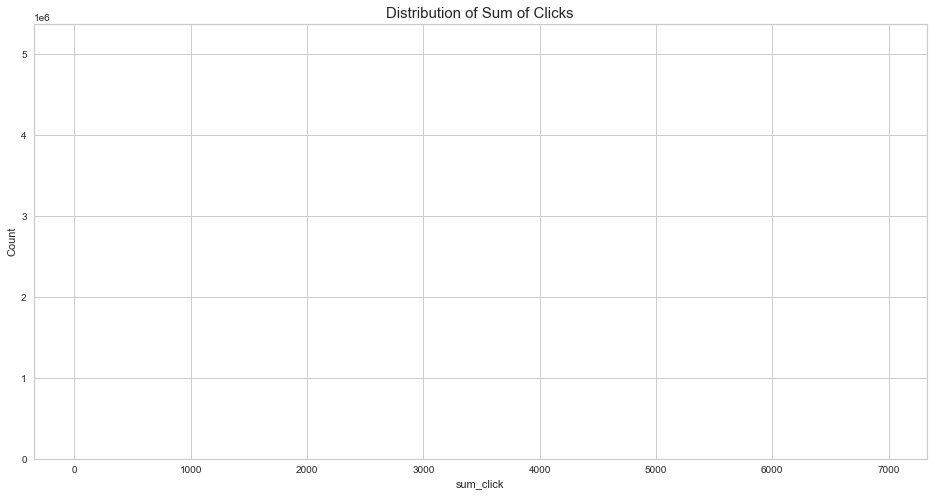

In [20]:
plt.figure(figsize=(16,8))
sns.histplot(df_studentVle['sum_click'], kde=False)
plt.title("Distribution of Sum of Clicks", fontsize=15)
plt.show()

**Outliers**

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


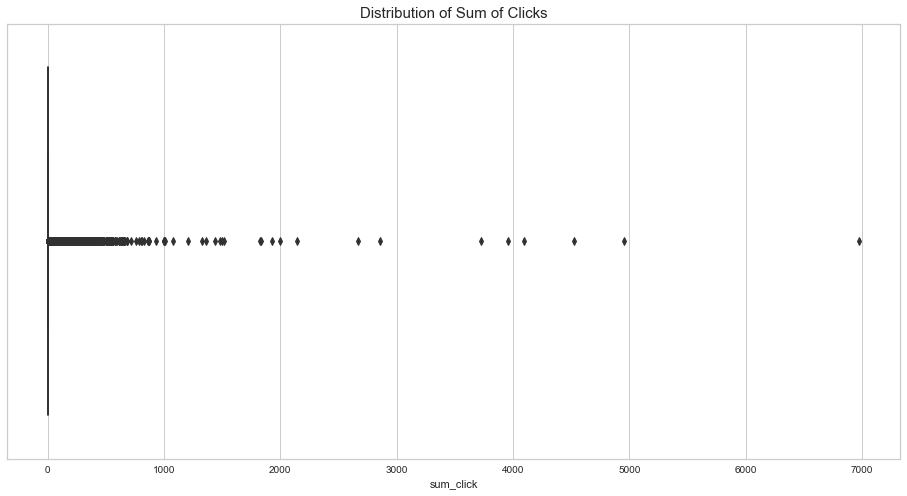

In [24]:
plt.figure(figsize=(16,8))
sns.boxplot(df_studentVle['sum_click']);
plt.title("Distribution of Sum of Clicks", fontsize=15)
plt.show()

In [26]:
columns = ['sum_click']
for column in df_studentVle[columns]:
    df1_Q1 = df_studentVle[column].describe()['25%']
    print("Q1", df1_Q1)
    df1_Q3 = df_studentVle[column].describe()['75%']
    print("Q3", df1_Q3)
    df1_IQR = df1_Q3 - df1_Q1
    print("IQR", df1_IQR)
    # Any number greater than this is a suspected outlier.
    df1_ub = (df1_Q3 +1.5*df1_IQR)
    print("Upper Bound", df1_ub)
    # Any number less than this is a suspected outlier.
    df1_lb = (df1_Q1 -1.5*df1_IQR)
    print("Lower Bound", df1_lb)

Q1 1.0
Q3 3.0
IQR 2.0
Upper Bound 6.0
Lower Bound -2.0


# Clustering 

## K-means 

In [9]:
# Sum of clicks dataframe for K-means 
sc_kmeans_df = df_studentVle['sum_click']
sc_kmeans_df.head()

0     4
1     1
2     1
3    11
4     1
Name: sum_click, dtype: int64

**Data Reshape**
- Reshape data to be 2D not 1D as fitting a model requires a 2D array 

In [10]:
sc_kmeans_df = sc_kmeans_df.values.reshape(-1,1)

In [11]:
sc_kmeans_df

array([[4],
       [1],
       [1],
       ...,
       [3],
       [1],
       [1]], dtype=int64)

### Data Standardization

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [13]:
# Standardize Sum of Clicks for kmeans 
sc_kmeans_df = scaler.fit_transform(sc_kmeans_df)

In [14]:
sc_kmeans_df

array([[ 0.03198696],
       [-0.30703262],
       [-0.30703262],
       ...,
       [-0.08101956],
       [-0.30703262],
       [-0.30703262]])

### Selecting the Optimal Number of Clusters
- Silhouette Method
- Gap Statistics 

**Gap Statistics**

In [15]:
# Gap Statistic for K means
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k, random_state =10)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)

In [16]:
start_time = time.time()
score_g, df = optimalK(sc_kmeans_df, nrefs=5, maxClusters=30)
end_time = time.time()

In [17]:
elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')

Execution time: 18621.754524707794 seconds


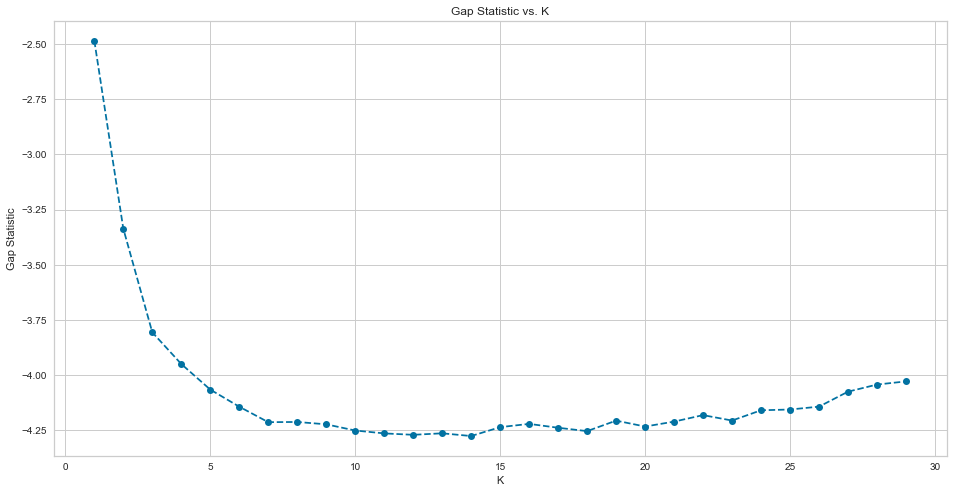

In [18]:
plt.figure(figsize=(16,8))
plt.plot(df['clusterCount'], df['gap'], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Gap Statistic');
plt.title('Gap Statistic vs. K');

In [37]:
df2 = df[df.gap == df.gap.max()]
print('Optimal number of clusters based on gap statistic:', df2['clusterCount'].tolist())

Optimal number of clusters based on gap statistic: [1.0]


**Elbow Method**

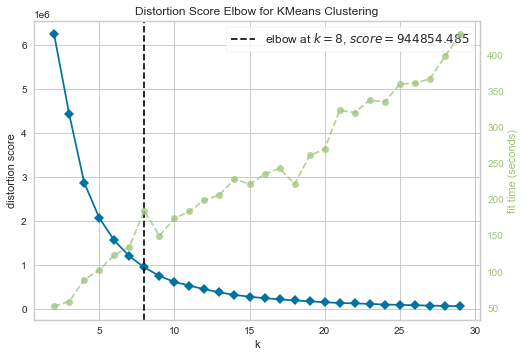

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [35]:
# Elbow Method for K means
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(random_state =10)
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
# Fit the data to the visualizer
visualizer.fit(sc_kmeans_df)        
visualizer.show() 

**Silhouette Method**

In [ ]:
# Silhouette Score for K means
from yellowbrick.cluster import KElbowVisualizer
sm_model = KMeans(random_state =10)
# k is range of number of clusters.
visualizer = KElbowVisualizer(sm_model, k=(2,30),metric='silhouette', timings= True, locate_elbow=False)
# Fit the data to the visualizer
visualizer.fit(sc_kmeans_df)   
visualizer.show()       

In [ ]:
sm_df = pd.DataFrame(visualizer.k_values_,columns=['centers'])
sm_df['scores'] = visualizer.k_scores_
sm_df2 = sm_df[sm_df.scores == sm_df.scores.max()]
print('Optimal number of clusters based on silhouette score:', sm_df2['centers'].tolist())

## Gaussian Mixture Model

In [43]:
# Sum of clicks dataframe for GMM 
sc_gmm_df = df_studentVle['sum_click']
sc_gmm_df = sc_gmm_df.values.reshape(-1,1)
sc_gmm_df

array([[4],
       [1],
       [1],
       ...,
       [3],
       [1],
       [1]], dtype=int64)

### Selecting the Optimal Number of Clusters/Components
- Bayesian Information criterion (BIC)
- Akaike Information Criterion (AIC)

In [44]:
# BIC and AIC for GMM 
from sklearn.mixture import GaussianMixture
n_components = range(1, 30)
covariance_type = ['spherical', 'tied', 'diag', 'full']
bic_score = []
aic_score = []
start_time = time.time()
for cov in covariance_type:
    for n_comp in n_components:
        gmm = GaussianMixture(n_components=n_comp,covariance_type=cov, random_state = 10)
        gmm.fit(sc_gmm_df)
        bic_score.append((cov,n_comp,gmm.bic(sc_gmm_df)))
        aic_score.append((cov,n_comp,gmm.aic(sc_gmm_df)))
end_time = time.time()

In [45]:
elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')

Execution time: 28017.45046067238 seconds


**Optimal Number of Components with BIC**

In [46]:
bic_score_1 = pd.DataFrame(bic_score)
bic_score_1.columns = ['Covariance_Type', 'N_Components','BIC_Score']
bic_score_2 = bic_score_1[bic_score_1.BIC_Score == bic_score_1.BIC_Score.min()]
bic_score_2.head(n=2)

,Covariance_Type,N_Components,BIC_Score
113,full,27,-4.334681e+07


**Optimal Number of Components with AIC**

In [47]:
aic_score_1 = pd.DataFrame(aic_score)
aic_score_1.columns = ['Covariance_Type', 'N_Components','AIC_Score']
aic_score_2 = aic_score_1[aic_score_1.AIC_Score == aic_score_1.AIC_Score.min()]
aic_score_2.head(n=2)

,Covariance_Type,N_Components,AIC_Score
113,full,27,-4.334795e+07


**BIC and AIC for Spherical Covariance**

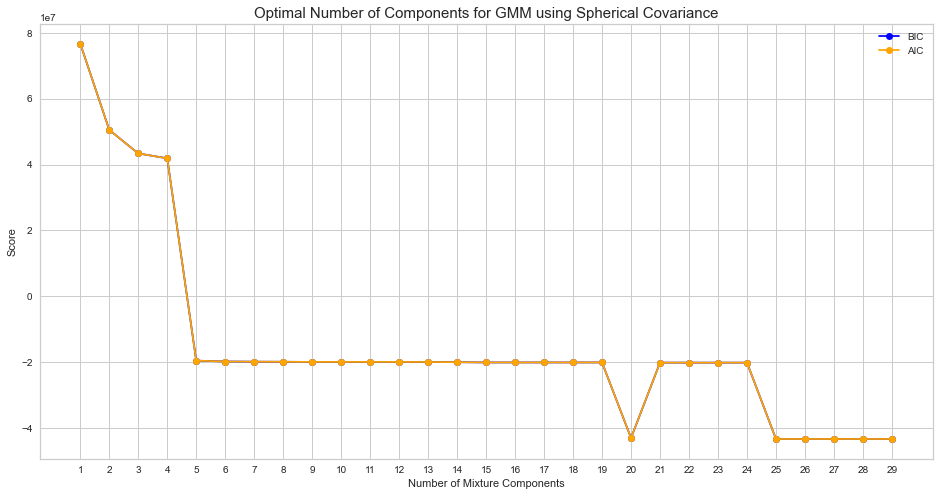

In [105]:
# Plot the BIC and AIC values together
fig, ax = plt.subplots(figsize=(16,8),nrows=1)
ax.plot(n_components, bic_score_1.iloc[0:29,:]['BIC_Score'], '-o', color='blue', label = 'BIC')
ax.plot(n_components, aic_score_1.iloc[0:29,:]['AIC_Score'], '-o', color='orange', label = 'AIC')
ax.set(xlabel='Number of Mixture Components', ylabel='Score')
ax.set_xticks(n_components)
ax.set_title('Optimal Number of Components for GMM using Spherical Covariance', fontsize=15);
plt.legend();

**BIC and AIC for Tied Covariance**

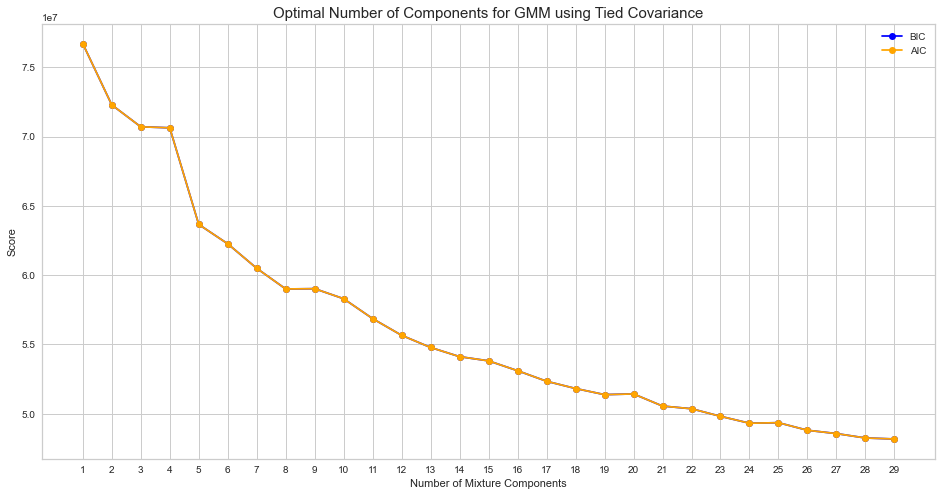

In [103]:
# Plot the BIC and AIC values together
fig, ax = plt.subplots(figsize=(16,8),nrows=1)
ax.plot(n_components, bic_score_1.iloc[29:58,:]['BIC_Score'], '-o', color='blue', label = 'BIC')
ax.plot(n_components, aic_score_1.iloc[29:58,:]['AIC_Score'], '-o', color='orange', label = 'AIC')
ax.set(xlabel='Number of Mixture Components', ylabel='Score')
ax.set_xticks(n_components)
ax.set_title('Optimal Number of Components for GMM using Tied Covariance', fontsize=15);
plt.legend();

**BIC and AIC for Diag Covariance**

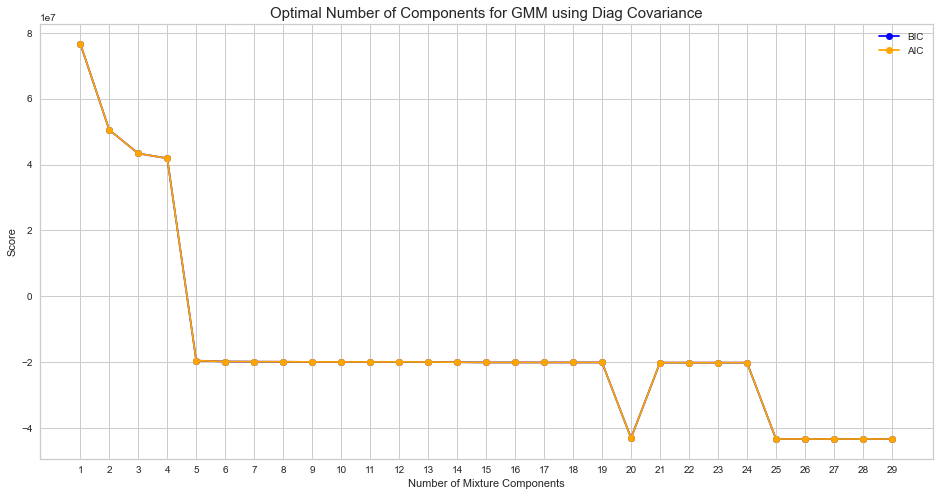

In [101]:
# Plot the BIC and AIC values together
fig, ax = plt.subplots(figsize=(16,8),nrows=1)
ax.plot(n_components, bic_score_1.iloc[58:87,:]['BIC_Score'], '-o', color='blue', label = 'BIC')
ax.plot(n_components, aic_score_1.iloc[58:87,:]['AIC_Score'], '-o', color='orange', label = 'AIC')
ax.set(xlabel='Number of Mixture Components', ylabel='Score')
ax.set_xticks(n_components)
ax.set_title('Optimal Number of Components for GMM using Diag Covariance', fontsize=15);
plt.legend();

**BIC and AIC for Full Covariance**

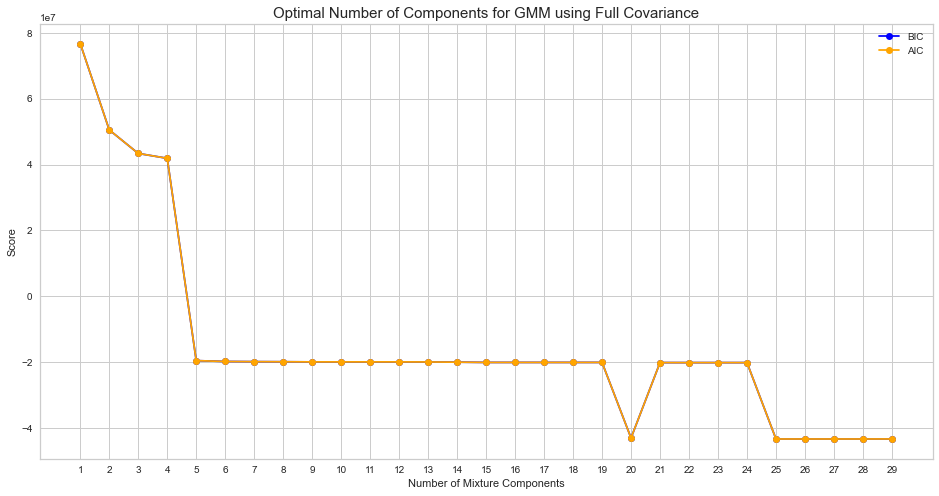

In [100]:
# Plot the BIC and AIC values together
fig, ax = plt.subplots(figsize=(16,8),nrows=1)
ax.plot(n_components, bic_score_1.iloc[87:116,:]['BIC_Score'], '-o', color='blue', label = 'BIC')
ax.plot(n_components, aic_score_1.iloc[87:116,:]['AIC_Score'], '-o', color='orange', label = 'AIC')
ax.set(xlabel='Number of Mixture Components', ylabel='Score')
ax.set_xticks(n_components)
ax.set_title('Optimal Number of Components for GMM using Full Covariance', fontsize=15);
plt.legend();

**BIC**

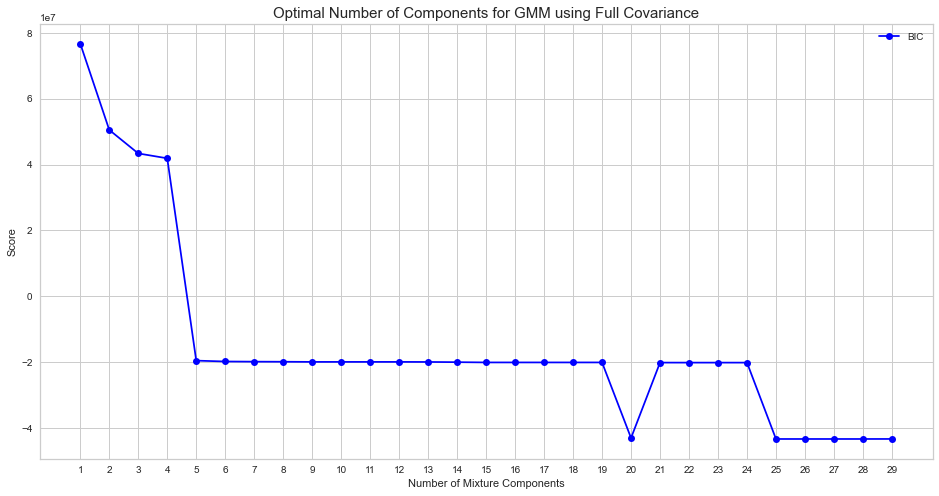

In [108]:
plt.figure(figsize=(16,8))
plt.plot(n_components, bic_score_1.iloc[87:116,:]['BIC_Score'], '-o', color='blue', label = 'BIC')
plt.xlabel('Number of Mixture Components')
plt.ylabel('Score')
plt.xticks(n_components)
plt.title('Optimal Number of Components for GMM using Full Covariance', fontsize=15);
plt.legend();

**AIC**

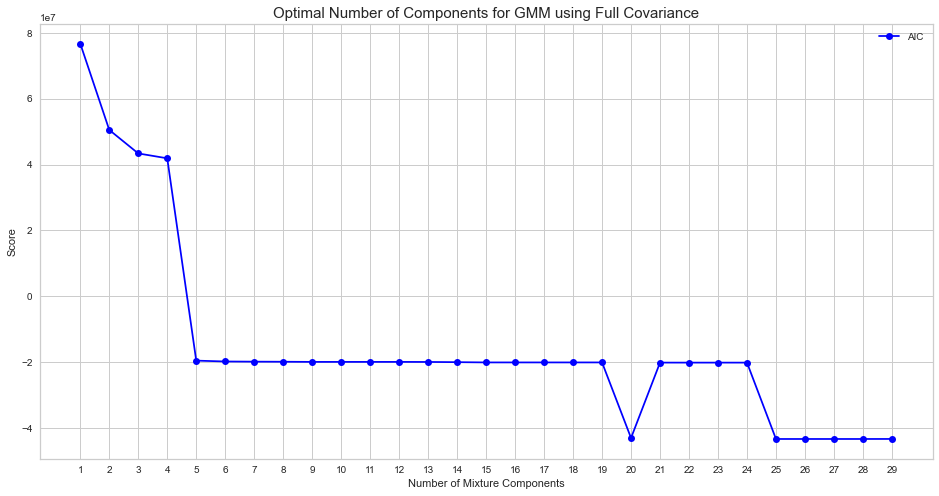

In [111]:
plt.figure(figsize=(16,8))
plt.plot(n_components, aic_score_1.iloc[87:116,:]['AIC_Score'], '-o', color='blue', label = 'AIC')
plt.xlabel('Number of Mixture Components')
plt.ylabel('Score')
plt.xticks(n_components)
plt.title('Optimal Number of Components for GMM using Full Covariance', fontsize=15);
plt.legend();

## K-means Model
- **Optimal Number of Clusters: 8**

In [114]:
# Fit K-Means
kmeans_model = KMeans(n_clusters=8, random_state= 10)

In [115]:
# Use fit_predict to cluster the dataset
start_time = time.time()
kmeans_predictions = kmeans_model.fit_predict(sc_kmeans_df)
end_time = time.time()

**Kmeans Clustering Time**

In [116]:
elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')

Execution time: 81.296884059906 seconds


**Kmeans Cluster Means**

In [122]:
kmeans_centers = kmeans_model.cluster_centers_
kmeans_centers

array([[-2.15004857e-01],
       [ 4.94306619e+00],
       [ 5.31351017e+02],
       [ 9.92748278e+00],
       [ 2.06340836e+00],
       [ 2.90556873e+01],
       [ 5.65701248e-01],
       [ 1.75220358e+02]])

In [134]:
kmeans_centers_inv = scaler.inverse_transform(kmeans_centers)
kmeans_centers_inv

array([[1.81435795e+00],
       [4.74583672e+01],
       [4.70566667e+03],
       [9.15657000e+01],
       [2.19761419e+01],
       [2.60832066e+02],
       [8.72286237e+00],
       [1.55425000e+03]])

https://www.calculatorsoup.com/calculators/math/scientific-notation-converter.php

**Kmeans Evaluation**

In [ ]:
# Calculate cluster validation metrics
kemans_ss = silhouette_score(sc_kmeans_df, kmeans_model.labels_, metric='euclidean')
kemans_chs = calinski_harabasz_score(sc_kmeans_df, kmeans_model.labels_)
kemans_dbs = davies_bouldin_score(sc_kmeans_df, kmeans_predictions)

In [ ]:
print('Silhouette Score: %.4f' % kemans_ss)
print('Calinski Harabasz Score: %.4f' % kemans_chs)
print('Davies Bouldin Score: %.4f' % kemans_dbs)

## GMM Model
- **Optimal Number of Components: 27**

In [ ]:
# gaussian mixture clustering
# define the model
gmm_model = GaussianMixture(n_components= 27, covariance_type= "full", random_state = 10)

In [ ]:
# fit the model
start_time = time.time()
gmm_model.fit(sc_gmm_df)
end_time = time.time()

**GMM Clustering Time**

In [ ]:
elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')

In [ ]:
# assign a cluster to each example
start_time = time.time()
gmm_predictions = gmm_model.predict(sc_gmm_df)
end_time = time.time()

In [ ]:
elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')

**GMM Cluster Means**

In [ ]:
gmm_model.means_

In [ ]:
# retrieve unique clusters
from numpy import unique
gmm_clusters = unique(gmm_predictions)

**GMM Evaluation**

In [ ]:
# Calculate cluster validation score
gmm_ss = silhouette_score(sc_gmm_df, gmm_predictions, metric='euclidean')
gmm_chs = calinski_harabasz_score(sc_gmm_df, gmm_predictions)
gmm_dbs = davies_bouldin_score(sc_gmm_df, gmm_predictions)

In [ ]:
print('Silhouette Score: %.4f' % gmm_ss)
print('Calinski Harabasz Score: %.4f' % gmm_chs)
print('Davies Bouldin Score: %.4f' % gmm_dbs)